# Chapter 18: Linear Regression

In this lecture, we’ll use the Python package `statsmodels` to estimate, interpret, and visualize linear regression models. 

As an example, we will replicate results from Acemoglu, Johnson and Robinson’s seminal [paper](https://economics.mit.edu/files/4123). This paper wish to determine whether or not differences in institutions can help to explain observed economic outcomes:

* economic outcomes are proxied by log GDP per capita in 1995, adjusted for exchange rates.

* institutional differences are proxied by an index of protection against expropriation on average over 1985-95, constructed by the Political Risk Services Group.



### 18.3 Simple Linear Regression

In [1]:
import pandas as pd
df1 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable1.dta')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let’s use a scatterplot to see whether any obvious relationship exists between GDP per capita and the protection against expropriation index

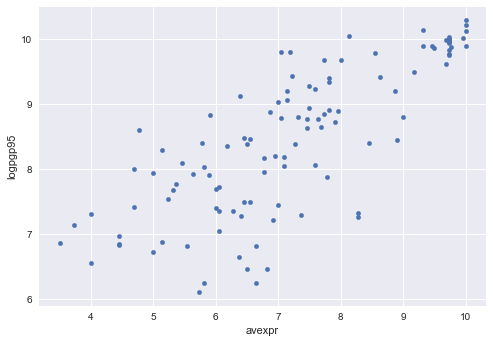

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.style.use('seaborn')
df1.plot(x='avexpr', y='logpgp95', kind='scatter')
plt.show()

We can write our model as:
$$𝑙𝑜𝑔𝑝𝑔𝑝95_𝑖 = 𝛽_0 + 𝛽_1 𝑎𝑣𝑒𝑥𝑝𝑟𝑖 + 𝑢_i$$
where:
* 𝛽_0 is the intercept of the linear trend line on the y-axis
* 𝛽_1 is the slope of the linear trend line, representing the marginal effect of protection against risk on log GDP per capita
* 𝑢_𝑖 is a random error term (deviations of observations from the linear trend due to fac- tors not included in the model)

Visually, this linear model involves choosing a straight line that best fits the data, as in the following plot.

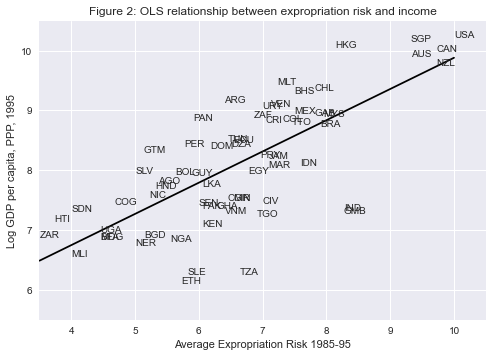

In [9]:
import numpy as np
# Dropping NA's is required to use numpy's polyfit
df1_subset = df1.dropna(subset=['logpgp95', 'avexpr']) # Use only 'base sample' for plotting purposes
df1_subset = df1_subset[df1_subset['baseco'] == 1]
X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']
# Replace markers with country labels
plt.scatter(X, y, marker='')

for i, label in enumerate(labels):
    plt.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
plt.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')
plt.xlim([3.5,10.5])
plt.ylim([5.5,10.5])
plt.xlabel('Average Expropriation Risk 1985-95')
plt.ylabel('Log GDP per capita, PPP, 1995')
plt.title('Figure 2: OLS relationship between expropriation risk and income')
plt.show()

In [11]:
import statsmodels.api as sm
# add constant column
df1['const'] = 1

reg1 = sm.OLS(endog=df1['logpgp95'], exog=df1[['const', 'avexpr']], missing='drop')
type(reg1)

statsmodels.regression.linear_model.OLS

In [13]:
# We need to use .fit() to obtain parameter estimates
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [14]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           4.16e-24
Time:                        15:46:58   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

Using our parameter estimates, we can now write our estimated relationship as

$$𝑙𝑜𝑔𝑝𝑔𝑝95_𝑖 = 4.63 + 0.53 𝑎𝑣𝑒𝑥𝑝𝑟_𝑖$$

We can use `.predict()` and set $𝑐𝑜𝑛𝑠𝑡𝑎𝑛𝑡 = 1$ and $𝑎𝑣𝑒𝑥𝑝𝑟𝑖 = 𝑚𝑒𝑎𝑛_𝑒𝑥𝑝𝑟$ to obtain prediction.

In [16]:
mean_expr = np.mean(df1_subset['avexpr'])
results.predict(exog=[1, mean_expr])

array([8.09156367])

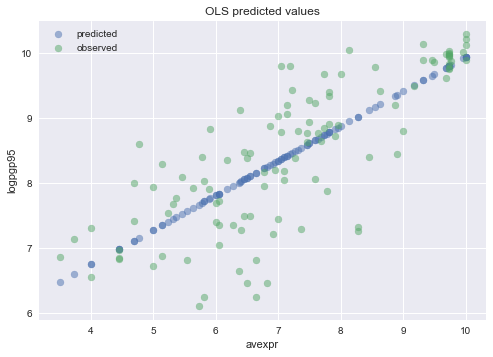

In [17]:
# Drop missing observations from whole sample
df1_plot = df1.dropna(subset=['logpgp95', 'avexpr'])
# Plot predicted values
plt.scatter(df1_plot['avexpr'], results.predict(), alpha=0.5, label='predicted')
# Plot observed values
plt.scatter(df1_plot['avexpr'], df1_plot['logpgp95'], alpha=0.5, label='observed')
plt.legend()
plt.title('OLS predicted values')
plt.xlabel('avexpr')
plt.ylabel('logpgp95')
plt.show()


### 18.4 Extending the Linear Regression Model

We can extend our bivariate regression model to a multivariate regression model by adding in other factors that may affect $𝑙𝑜𝑔𝑝𝑔𝑝95_i$. Consider other factors such as:
* the effect of climate on economic outcomes; latitude is used to proxy this
* differences that affect both economic performance and institutions, eg. cultural, historical, etc.; controlled for with the use of continent dummies

In [19]:
df2 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable2.dta')
# Add constant term to dataset
df2['const'] = 1
# Create lists of variables to be used in each regression
X1 = ['const', 'avexpr']
X2 = ['const', 'avexpr', 'lat_abst']
X3 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']
# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df2['logpgp95'], df2[X1], missing='drop').fit()
reg2 = sm.OLS(df2['logpgp95'], df2[X2], missing='drop').fit()
reg3 = sm.OLS(df2['logpgp95'], df2[X3], missing='drop').fit()

Now that we have fitted our model, we will use summary_col to display the results in a single table (model numbers correspond to those in the paper)

In [20]:
from statsmodels.iolib.summary2 import summary_col 
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}", 
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3], 
                            float_format='%0.2f', 
                            stars = True, 
                            model_names=['Model 1','Model 3','Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const','avexpr','lat_abst','asia','africa'])
results_table.add_title('Table 2 - OLS Regressions')
print(results_table)

        Table 2 - OLS Regressions
                 Model 1 Model 3 Model 4 
-----------------------------------------
const            4.63*** 4.87*** 5.85*** 
                 (0.30)  (0.33)  (0.34)  
avexpr           0.53*** 0.46*** 0.39*** 
                 (0.04)  (0.06)  (0.05)  
lat_abst                 0.87*   0.33    
                         (0.49)  (0.45)  
asia                             -0.15   
                                 (0.15)  
africa                           -0.92***
                                 (0.17)  
other                            0.30    
                                 (0.37)  
R-squared        0.61    0.62    0.72    
R-squared Adj.   0.61    0.62    0.70    
R-squared        0.61    0.62    0.72    
No. observations 111     111     111     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### 18.5 Endogeneity

There is likely a two-way relationship between institutions and economic outcomes:
* richer countries may be able to afford or prefer better institutions
* variables that affect income may also be correlated with institutional differences
* the construction of the index may be biased; analysts may be biased towards seeing
countries with higher income having better institutions

The main contribution of paper is the use of settler mortality rates to instrument for institutional differences. Using a scatterplot, we can see protection against expropriation is negatively correlated with settler mortality rates, coinciding with the authors’ hypothesis and satisfying the first condition of a valid instrument

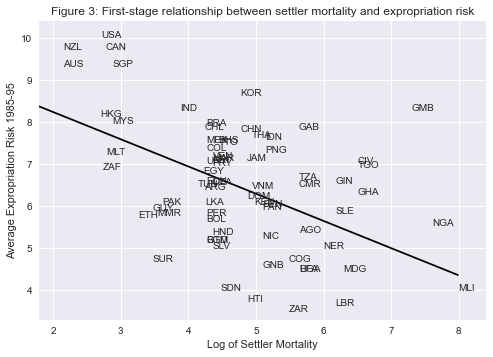

In [22]:
# Dropping NA's is required to use numpy's polyfit 
df1_subset2 = df1.dropna(subset=['logem4', 'avexpr'])
X = df1_subset2['logem4']
y = df1_subset2['avexpr']
labels = df1_subset2['shortnam']

# Replace markers with country labels

plt.scatter(X, y, marker='')
for i, label in enumerate(labels):
    plt.annotate(label, (X.iloc[i], y.iloc[i]))
    
# Fit a linear trend line
plt.plot(np.unique(X),
      np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
      color='black')
plt.xlim([1.8,8.4])
plt.ylim([3.3,10.4])
plt.xlabel('Log of Settler Mortality')
plt.ylabel('Average Expropriation Risk 1985-95')
plt.title('Figure 3: First-stage relationship between settler mortality and expropriation risk')
plt.show()